In [14]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def extract_metrics(log_file, param_keys, max_gpus=2):
    metrics = {
        "overall_latencies": [],
        "overall_throughput": [],
        "request_latencies": [],
        "counts_all": [],
        "request_llm_metrics": [],
        "finished_llm_metrics": [],
        "prefill_ratio": [],
    }

    param_format = f"Params=\({'(.+?), ' * (len(param_keys)-1)}(.+?)\)"
    patterns = {
        "Overall Latency": ("overall_latencies", f"{param_format} Overall Latency: (.*)"),
        "Overall Throughput": ("overall_throughput", f"{param_format} Overall Throughput: (.*)"),
        "Overall Request Latency": ("request_latencies", f"{param_format} Overall Request Latency: (.*), STD: (.*), P90: (.*)"),
        "Average TTFT": ("request_llm_metrics", f"{param_format} Average TTFT: (.*), Average TOPT: (.*), Throughput ToksPerSec: (.*)"),
        "Num Finished Requests": ("finished_llm_metrics", f"{param_format} Num Finished Requests: (.*), Finished Throughput ToksPerSec: (.*)"),
        "Counts": ("counts_all", f"{param_format} Counts: (.*)"),
        'Overall PrefillRatio': ("prefill_ratio", f"{param_format} Overall PrefillRatio: (.*)")
    }
    
    with open(log_file, 'r') as f:
        for line in f:
            for key, (metric_key, pattern) in patterns.items():
                if key in line:
                    match = re.search(pattern, line)
                    if match:
                        data = {param_key: match.group(i+1) for i, param_key in enumerate(param_keys)}
                        # Parse specific data based on metric type
                        if metric_key in ["overall_latencies", "overall_throughput"]:
                            data.update({"value": float(match.group(len(param_keys)+1))})
                        elif metric_key == "request_llm_metrics":
                            data.update({"ttft": float(match.group(len(param_keys)+1)), "topt": float(match.group(len(param_keys)+2)), "throughput_tkns_per_sec": float(match.group(len(param_keys)+3))})
                        elif metric_key == "request_latencies":
                            data.update({"avg_latency": float(match.group(len(param_keys)+1)), "std": float(match.group(len(param_keys)+2)), "p90": float(match.group(len(param_keys)+3))})
                        elif metric_key == "finished_llm_metrics":
                            data.update({"num_finished": int(match.group(len(param_keys)+1)), "throughput_finished_tkns_per_sec": float(match.group(len(param_keys)+2))})
                        elif metric_key == "prefill_ratio":
                            data.update({"prefill_ratio": float(match.group(len(param_keys)+1))})
                        elif metric_key == "counts_all":
                            # Note: Using eval() can be risky and is generally not recommended
                            count_ratio = eval(match.group(len(param_keys)+1))
                            ratios = {int(k): float(v) for k, v in count_ratio.items()}
                            data.update({"counts_all": ratios, "ratio": ratios[0]/(ratios[0]+ratios[1])})
                        metrics[metric_key].append(data)
    policy_data = collect_policy_data(log_file, max_gpus=max_gpus)
    metrics["scheduling_dynamics"] = policy_data
    return metrics

# Usage example (ensure you replace `log_file` with the actual log file path and adjust `param_keys` as needed)

def prepare_data_for_plotting(metric_data, metric_key, title, policy_replacements=None, group_by_key=None,baseline_key="RANDOM", speedup_direction="lower"):
    df = pd.DataFrame(metric_data)
    if not df.empty:
        df = df.drop(["model_name", "percent_random_prefixes", "exp_time"], axis=1, errors='ignore')
        if policy_replacements:
            # print(df["policy"])
            for original, replacement in policy_replacements.items():
                df['policy'] = df['policy'].str.replace(original, replacement)
        df = df.groupby(['num_prefix', 'num_requests', 'rps', 'policy'])[group_by_key].mean().unstack()
        if baseline_key:
            df = calculate_speedup(df, baseline_policy=baseline_key, speedup_direction=speedup_direction)
        return df, title
    return None, None

def collect_policy_data(log_file, max_gpus=2):
    policy_data = []
    current_policy_info = {}
    max_hit_rate_gpu = {}
    waiting_queue_lengths = []

    def append_policy_data():
        """Helper function to append the current policy's data."""
        if current_policy_info:  # Check if there's data to append
            # Update with GPU hit rates and average waiting queue length
            for gpu_id, hit_rate in max_hit_rate_gpu.items():
                current_policy_info[f'max_tree_cache_hit_rate_gpu{gpu_id}'] = hit_rate
            current_policy_info['avg_waiting_queue_len'] = (
                sum(waiting_queue_lengths) / len(waiting_queue_lengths)
                if waiting_queue_lengths else 0
            )
            policy_data.append(current_policy_info)

    with open(log_file, 'r') as file:
        for line in file:
            if "=====STARTING Policy" in line:
                append_policy_data()  # Append data for the previous policy
                
                # Reset for new policy
                current_policy_info = {}
                max_hit_rate_gpu = {i: 0.0 for i in range(max_gpus)}  # Prepare for up to 8 GPUs
                waiting_queue_lengths = []

                # Extract policy and other properties
                match = re.search(r"=====STARTING Policy (.+?), (\d+) WORKLOADS, ([\d.]+) NON-SHARED, (\d+) REQUESTS, (.*) REQ/s", line)
                if match:
                    current_policy_info = {
                        'policy': match.group(1),
                        'num_prefix': int(match.group(2)),
                        'percent_random_prefixes': float(match.group(3)),
                        'num_requests': int(match.group(4)),
                        'rps': float(match.group(5)),
                    }
                
            elif "tree_cache_hit_rate" in line:
                gpu_id_match = re.search(r"GPU: (\d+)", line)
                hit_rate_match = re.search(r"tree_cache_hit_rate: ([\d.]+)%", line)
                waiting_queue_length_match = re.search(r"#remaining_req: (\d+)", line)

                if waiting_queue_length_match:
                    waiting_queue_lengths.append(int(waiting_queue_length_match.group(1)))

                if gpu_id_match and hit_rate_match:
                    gpu_id = int(gpu_id_match.group(1))
                    hit_rate = float(hit_rate_match.group(1))
                    if gpu_id in max_hit_rate_gpu:
                        max_hit_rate_gpu[gpu_id] = max(max_hit_rate_gpu[gpu_id], hit_rate)
    append_policy_data()  # Append data for the last policy
    return policy_data

def calculate_speedup(df, baseline_policy='RANDOM', speedup_column = f"speedup_over_random", speedup_direction="lower"):
    """
    Adds speedup columns to the DataFrame based on metrics compared to a baseline policy.
    
    :param df: DataFrame after groupby().mean().unstack(), where columns are policies.
    :param baseline_policy: The column name for the baseline policy to compare against.
    :param new_column_suffix: Suffix for the new speedup columns.
    """
    if baseline_policy in df.columns:
        for policy in df.columns:
            if policy != baseline_policy:
                if speedup_direction == "lower":
                    df[speedup_column] = df[baseline_policy] / df[policy]
                else:
                    df[speedup_column] = df[policy] / df[baseline_policy]
    return df

def plot_metrics(metrics, title_prefix, ax_dims=(4, 3), figsize=(28, 14), global_metric_dfs={}):
    fig, axes = plt.subplots(*ax_dims, figsize=figsize)
    plt.tight_layout(pad=6.0)
    
    # Ensure axes is always treated as an array, even when there's only one subplot
    axes = np.array(axes).reshape(-1)  # This handles both single and multiple Axes objects

    plot_configs = [
        {"metric_key": "overall_latencies", "title": "End to End Latency", "group_by_key": "value", 'speedup_direction': 'lower', "ylabel": "sec"},
        {"metric_key": "overall_throughput", "title": "Overall Throughput", "group_by_key": "value", 'speedup_direction': 'higher', "ylabel": "reqs/sec"},
        {"metric_key": "request_latencies", "title": "Average per request latency", "group_by_key": "avg_latency", 'speedup_direction': 'lower', "ylabel": "sec"},
        {"metric_key": "request_latencies", "title": "P90 per request latency", "group_by_key": "p90", 'speedup_direction': 'lower', "ylabel": "sec"},
        # TTFT
        {"metric_key": "request_llm_metrics", "title": "TTFT", "group_by_key": "ttft", 'speedup_direction': 'lower', "ylabel": "sec"},
        # TOPT
        {"metric_key": "request_llm_metrics", "title": "TOPT sec/tkn", "group_by_key": "topt", 'speedup_direction': 'lower', "ylabel": "sec/tkn"},
        # throughput_tkns_per_sec
        {"metric_key": "request_llm_metrics", "title": "Total Tokens/sec", "group_by_key": "throughput_tkns_per_sec", 'speedup_direction': 'higher', "ylabel": "tkns/sec"},
        {"metric_key": "finished_llm_metrics", "title": "Num finished 100s", "group_by_key": "num_finished", 'speedup_direction': 'higher', "ylabel": "# of requests"},
        {"metric_key": "counts_all", "title": "Ratio of GPU 0 /(GPU 0 + GPU 1) calls", "group_by_key": "ratio", 'speedup_direction': 'higher', "ylabel": "%"},

        # prefill ratio
        {"metric_key": "prefill_ratio", "title": "Prefill Ratio", "group_by_key": "prefill_ratio", 'speedup_direction': 'lower', "ylabel": "%"},

        # scheduling_dynamics
        {"metric_key": "scheduling_dynamics", "title": "Max Tree Cache Hit Rate GPU 0", "group_by_key": "max_tree_cache_hit_rate_gpu0", 'speedup_direction': 'higher', "ylabel": "%hit"},
        {"metric_key": "scheduling_dynamics", "title": "Avg Waiting Queue Length", "group_by_key": "avg_waiting_queue_len", 'speedup_direction': 'lower', "ylabel": "# requests"},
        # Define additional metric configurations as needed
    ]
    
    policy_replacements = {'DataParallelRuntimeSelectionPolicy.': '', 'CUSTOM-CustomPolicyType.': '', "-":''}  # Example replacement
    baseline_key = 'RANDOM'

    ax_index = 0
    for config in plot_configs:
        if ax_index >= len(axes):  # Prevent index out of range
            break
        metric_data = metrics.get(config["metric_key"], [])
        df, title = prepare_data_for_plotting(
            metric_data, 
            config["metric_key"], 
            config["title"], 
            policy_replacements, 
            speedup_direction=config.get('speedup_direction', 'lower'),
            group_by_key=config.get("group_by_key"),
            baseline_key=baseline_key) 
        if df is not None:
            global_metric_dfs[config["metric_key"]] = df  # Store dataframe globally
            ax = axes[ax_index]
            metric_columns = [col for col in df.columns if 'speedup_over_random' != col]
            bars = df[metric_columns].plot(kind='bar', ax=ax, title=f"{title_prefix} {title}", rot=0, ylabel="Value")
            for bar, speedup in zip(bars.get_children(), df['speedup_over_random']):
                if pd.notna(speedup):  # Check if speedup value exists and is not NaN
                    height = bar.get_height()
                    ax.annotate(f'{speedup:.2f}x',
                                xy=(bar.get_x() + bar.get_width() / 2, height),
                                xytext=(0, 3),  # 3 points vertical offset
                                textcoords="offset points",
                                ha='center', va='bottom')
            x_labels = []
            for idx in df[metric_columns].index:
                label = '\n'.join(str(val) for val in idx)
                x_labels.append(label)
            bars.set_xticklabels(x_labels)
            ax_index += 1

            # Customize the plot as needed

    # Hide unused subplots
    for i in range(ax_index, len(axes)):
        fig.delaxes(axes[i])


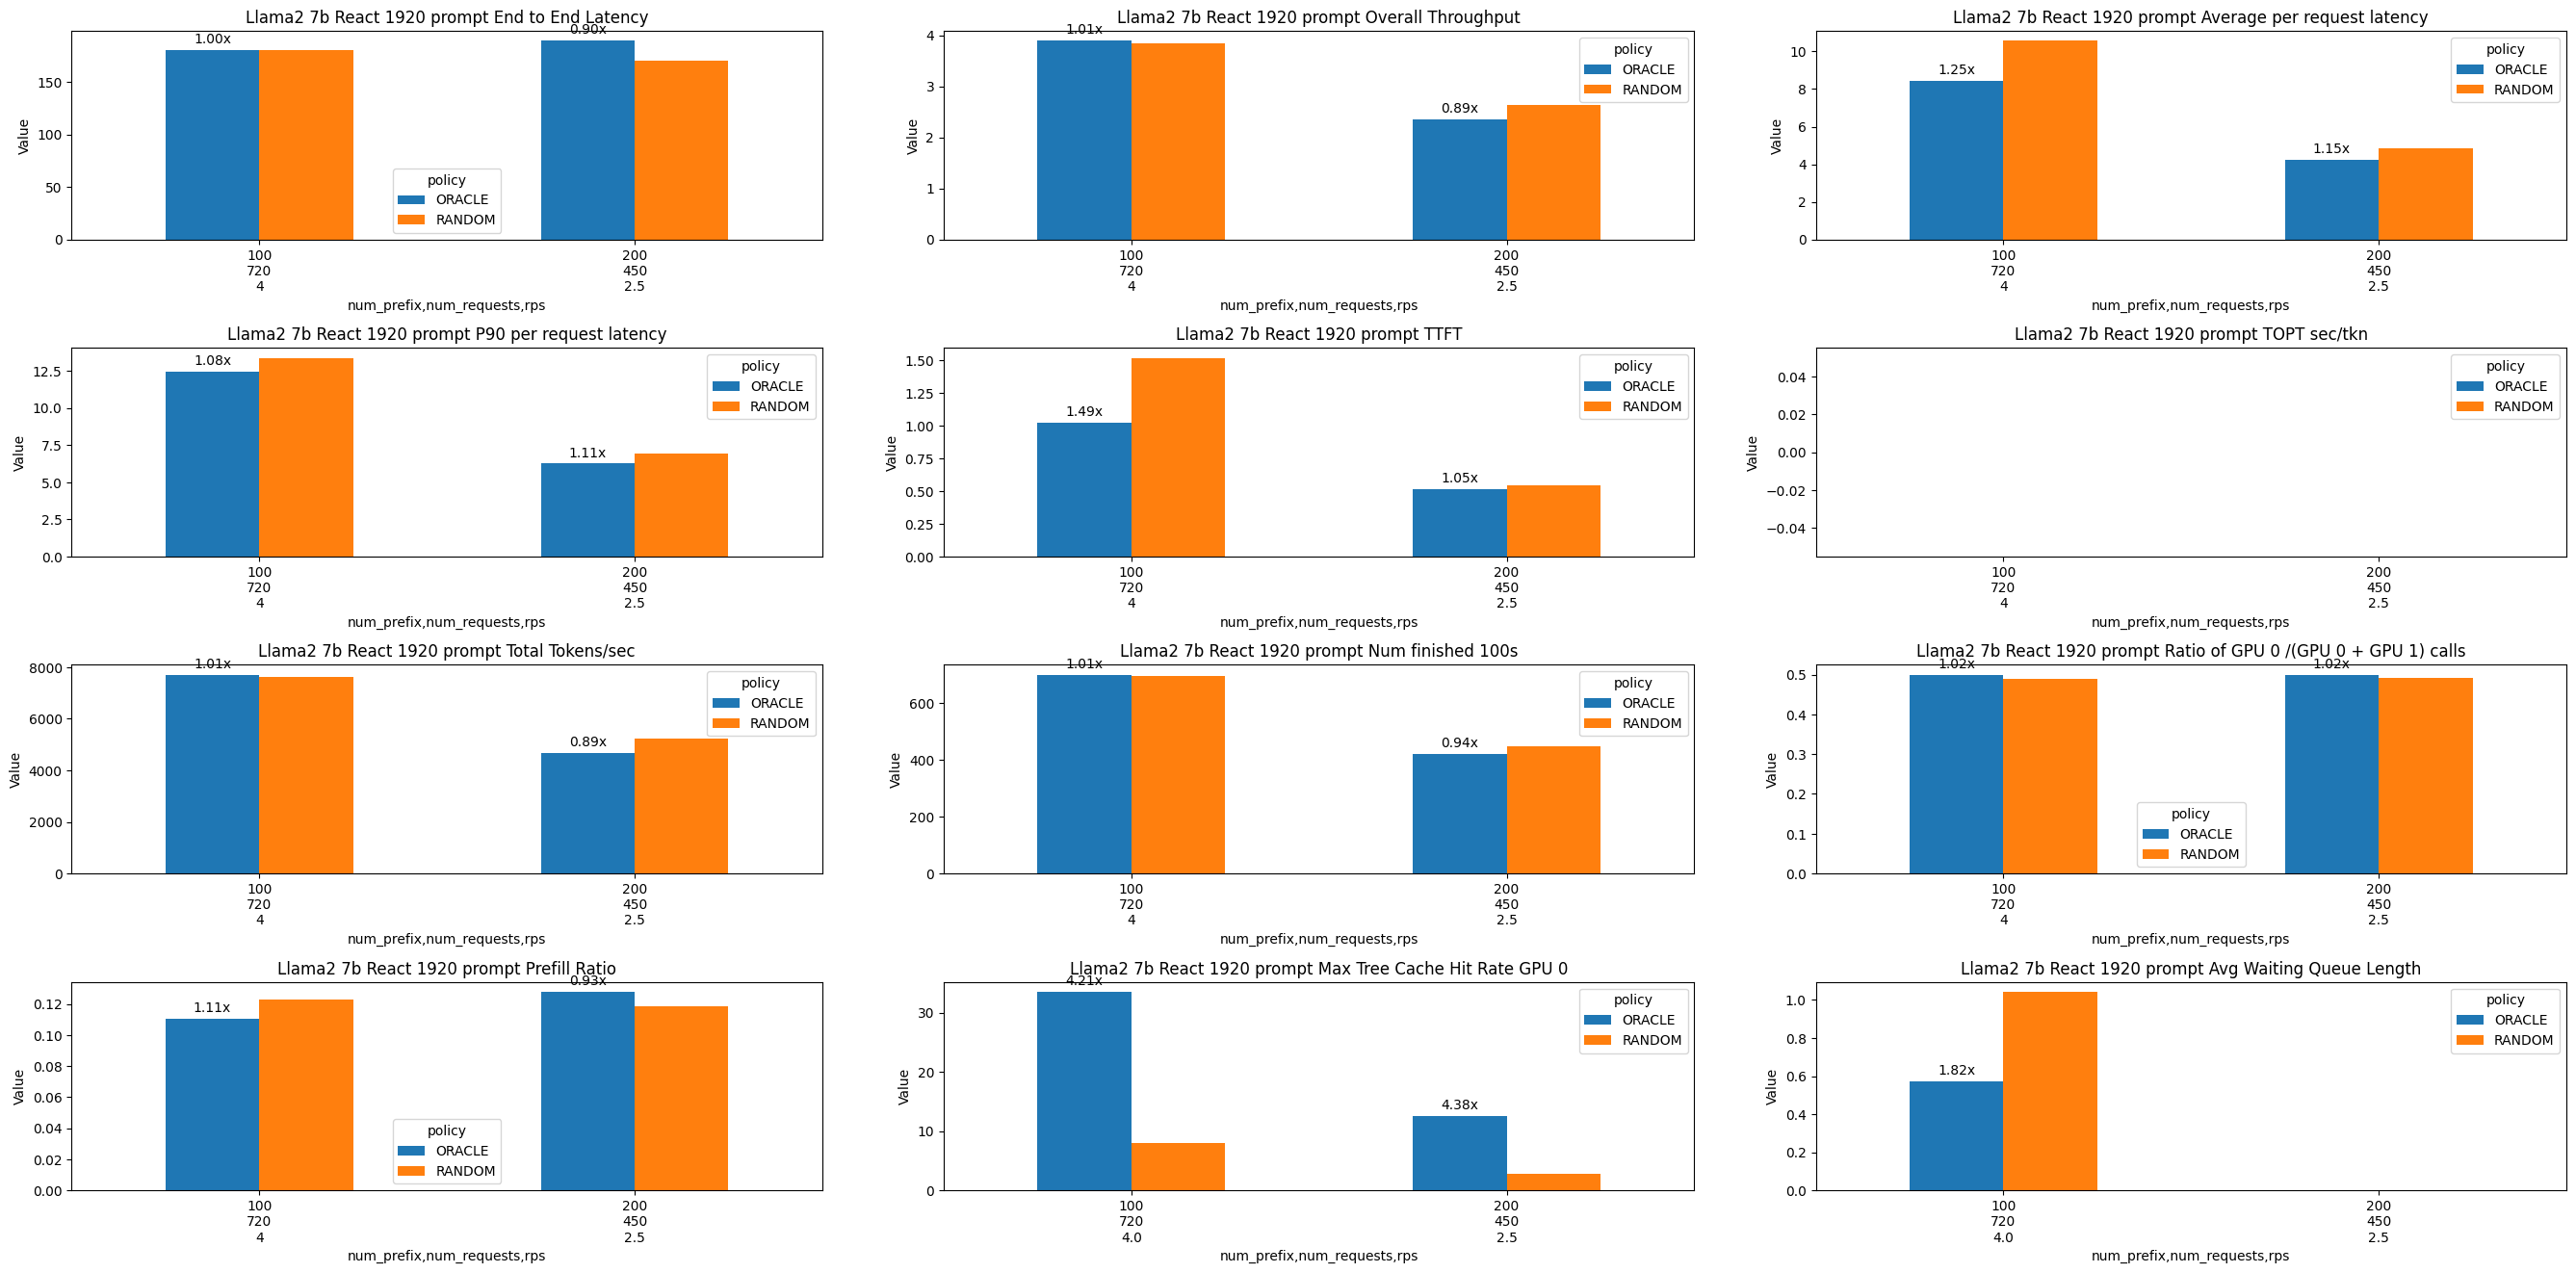

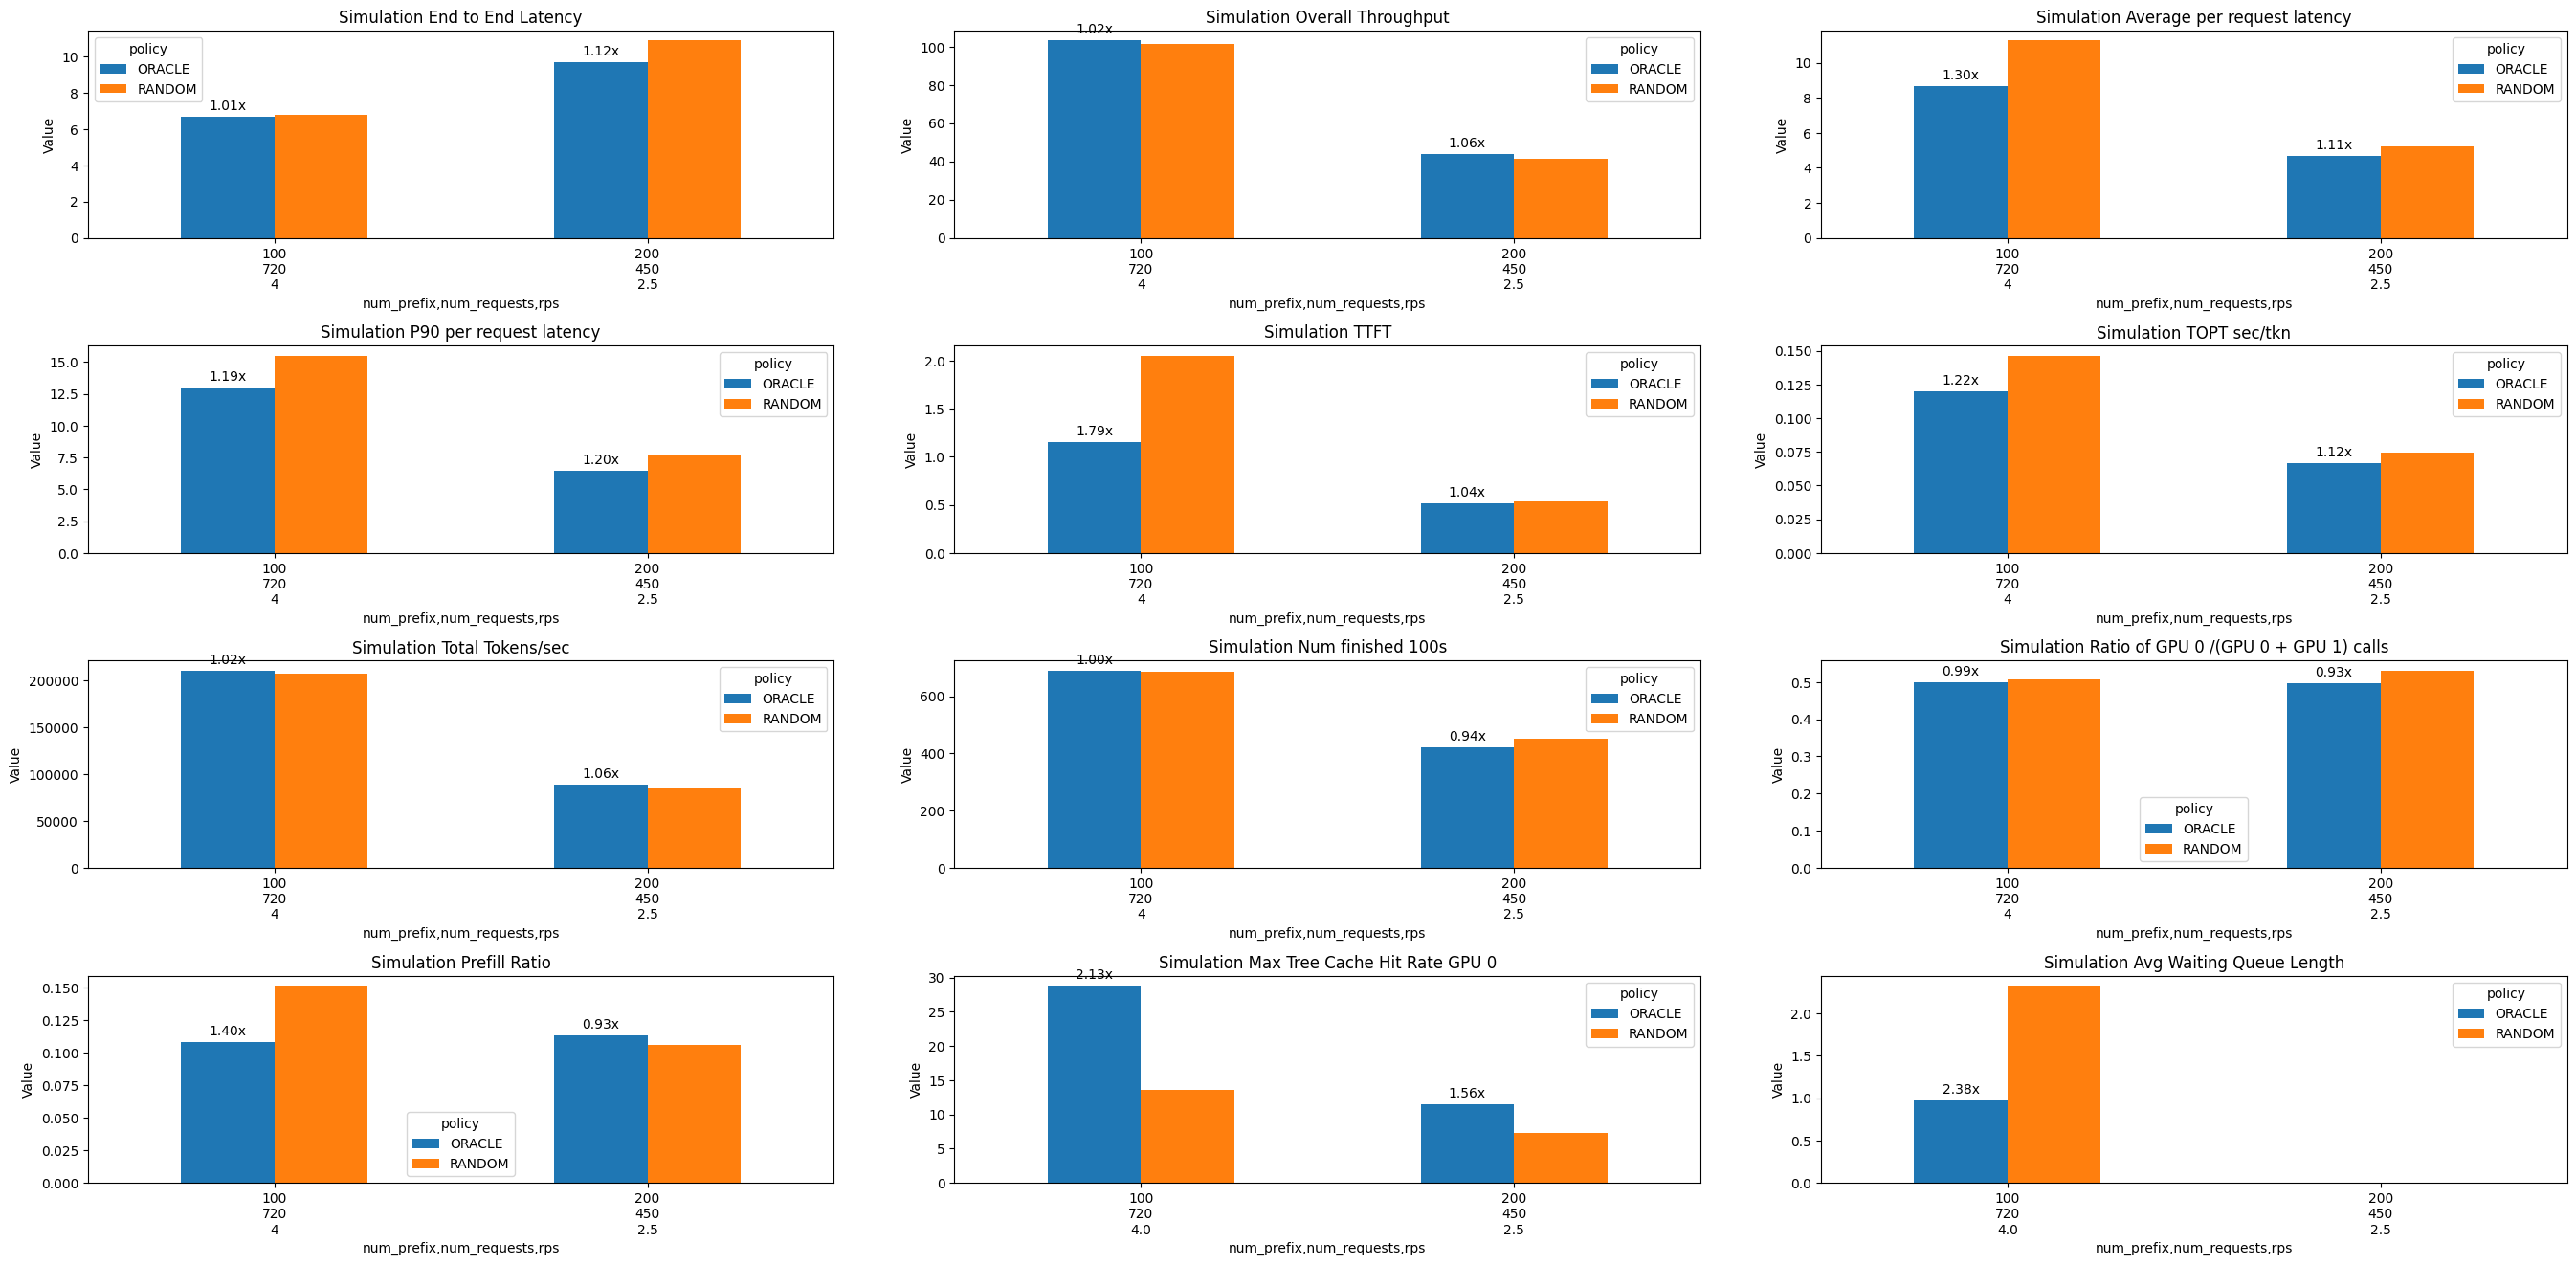

In [15]:
log_file = '../../ref_for_sim_2048.log'
param_keys = ["model_name", "num_prefix", "percent_random_prefixes", "num_requests", "rps", "policy", "exp_time"]
metrics = extract_metrics(log_file, param_keys, max_gpus=2)
global_metric_dfs_mistral = {}
plot_metrics(metrics, "Llama2 7b React 1920 prompt", global_metric_dfs=global_metric_dfs_mistral)
plt.savefig("reference.png")

simulator_log_file = '../../sim_2048.log'
param_keys = ["model_name", "num_prefix", "percent_random_prefixes", "num_requests", "rps", "policy", "exp_time"]
metrics = extract_metrics(simulator_log_file, param_keys, max_gpus=2)
global_metric_dfs_mistral_simulation = {}
plot_metrics(metrics, "Simulation", global_metric_dfs=global_metric_dfs_mistral_simulation)
plt.savefig("simulation.png")

In [6]:
global_metric_dfs_mistral.keys()

dict_keys(['overall_latencies', 'overall_throughput', 'request_latencies', 'request_llm_metrics', 'finished_llm_metrics', 'counts_all', 'prefill_ratio'])

In [62]:
# TTFT improvement is highest when lower RPS

Index(['ORACLE_B', 'RANDOM', 'speedup_over_random'], dtype='object', name='policy')

In [ ]:
request_latency_df

In [ ]:
request_llm_metrics_df_ttft

In [ ]:
#